#### Adapted from https://docs.llamaindex.ai/en/stable/examples/multi_modal/gpt4v_multi_modal_retrieval/

# Requirements

In [4]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client
%pip install llama-index-multi-modal-llms-azure-openai

# Understanding Documents and Nodes

In [4]:
from llama_index.core import Document

text_list = ["text1", "text2"]
documents = [Document(text=t) for t in text_list]

In [8]:
documents[0].dict

<bound method BaseComponent.dict of Document(id_='b3e5107d-16f9-4286-a222-7ef521d8b0d4', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='text1', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n')>

In [9]:
from llama_index.core.node_parser import SentenceSplitter

parser = SentenceSplitter()

nodes = parser.get_nodes_from_documents(documents)

In [10]:
nodes

[TextNode(id_='b6c776e4-e6eb-45d1-a119-8d908e60db1a', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='b3e5107d-16f9-4286-a222-7ef521d8b0d4', node_type=<ObjectType.DOCUMENT: '4'>, metadata={}, hash='1054cd58879227224b15575f139494357d91ae31a4d8afe79a4528364805f0c6'), <NodeRelationship.NEXT: '3'>: RelatedNodeInfo(node_id='96e8ed8a-e859-4b07-93c5-7fa508558196', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='2545275609636efcd326ea32ea363515eb1bb417aaa3983bd8ea135418939c83')}, text='text1', start_char_idx=0, end_char_idx=5, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'),
 TextNode(id_='96e8ed8a-e859-4b07-93c5-7fa508558196', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8e068eb5-b918-47be-96cb-87f

# Data Preprocessing

In [24]:
import os
from dotenv import load_dotenv

from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, ServiceContext

load_dotenv()

api_key = os.getenv["AZURE_OPENAI_API_KEY"]
azure_endpoint = os.getenv["AZURE_OPENAI_ENDPOINT"]
api_version = "2023-07-01-preview"

llm = AzureOpenAI(
    model="gpt-4",
    deployment_name="gpt-4",
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

# You need to deploy your own embedding model as well as your own chat completion model
embed_model = AzureOpenAIEmbedding(
    model="text-embedding-ada-002",
    deployment_name="text-embedding-ada-002",
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

from llama_index.multi_modal_llms.azure_openai import AzureOpenAIMultiModal



llm_vision = AzureOpenAIMultiModal(   
    engine="gpt-4-vision",
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version="2023-12-01-preview",
    model="gpt-4-vision-preview",
)

In [9]:
from llama_index.core import set_global_service_context

service_context = ServiceContext.from_defaults(
    llm=llm,
    embed_model=embed_model,
)
set_global_service_context(service_context)

C:\Users\vaalt\AppData\Local\Temp\ipykernel_21348\1672706003.py:3: DeprecationWarning: Call to deprecated class method from_defaults. (ServiceContext is deprecated, please use `llama_index.settings.Settings` instead.) -- Deprecated since version 0.10.0.
  service_context = ServiceContext.from_defaults(


In [28]:
from llama_index.core import Settings
Settings.llm = llm

In [15]:
# Output directory for the extracted images
output_dir = "extracted_images"
# Desired output image format
output_format = "jpeg"
# Minimum width and height for extracted images
min_width = 100
min_height = 100
# Create the output directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## Test wiki

In [4]:
import requests


def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls

In [54]:
from pathlib import Path
import requests
import urllib.request

image_uuid = 0
# image_metadata_dict stores images metadata including image uuid, filename and path
image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 20

wiki_titles = {
    "Rome",
    "Milan",
    "Venice",
    "Florence",
    "Bologna",
    "Palermo"
}


data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        # page_py = wikipedia.page(title)
        list_img_urls = get_wikipedia_images(title)
        # print(list_img_urls)

        for url in list_img_urls:
            if (
                url.endswith(".jpg")
                or url.endswith(".png")
                or url.endswith(".svg")
            ):
                image_uuid += 1
                # image_file_name = title + "_" + url.split("/")[-1]

                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

No images found for Wikipedia page: Bologna
No images found for Wikipedia page: Venice
No images found for Wikipedia page: Milan
No images found for Wikipedia page: Rome
No images found for Wikipedia page: Palermo
No images found for Wikipedia page: Florence


In [63]:
from PIL import Image
import os

def compress_and_save_images(folder_path, max_size_bytes=20 * 1024 * 1024):
    """
    Compresses images in the specified folder and saves them.
    :param folder_path: Path to the folder containing images.
    :param max_size_bytes: Maximum allowed file size in bytes (default: 20 MB).
    """
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepath = os.path.join(folder_path, filename)
            original_size = os.path.getsize(filepath)

            # Compress the image until its size is within the limit
            while original_size > max_size_bytes:
                img = Image.open(filepath)
                img.save(filepath, quality=85)  # Adjust quality as needed
                new_size = os.path.getsize(filepath)
                original_size = new_size

            print(f"{filename}: Initial Size: {original_size} bytes, Final Size: {new_size} bytes")

# Usage: Replace 'your_folder_path' with the actual path to your image folder
folder_to_compress = 'mixed_wiki'
compress_and_save_images(folder_to_compress)

1.jpg: Initial Size: 3874842 bytes, Final Size: 3874842 bytes
10.jpg: Initial Size: 5260159 bytes, Final Size: 3874842 bytes
11.jpg: Initial Size: 10100642 bytes, Final Size: 10100642 bytes
12.jpg: Initial Size: 2401158 bytes, Final Size: 10100642 bytes
13.jpg: Initial Size: 1641707 bytes, Final Size: 10100642 bytes
14.jpg: Initial Size: 6307 bytes, Final Size: 10100642 bytes
15.jpg: Initial Size: 392380 bytes, Final Size: 10100642 bytes
16.jpg: Initial Size: 76393 bytes, Final Size: 10100642 bytes
17.jpg: Initial Size: 9770865 bytes, Final Size: 10100642 bytes
18.jpg: Initial Size: 1148479 bytes, Final Size: 10100642 bytes
19.jpg: Initial Size: 405278 bytes, Final Size: 10100642 bytes
2.jpg: Initial Size: 1788510 bytes, Final Size: 10100642 bytes
20.jpg: Initial Size: 46220 bytes, Final Size: 10100642 bytes
22.jpg: Initial Size: 14002701 bytes, Final Size: 14002701 bytes
23.jpg: Initial Size: 6365880 bytes, Final Size: 14002701 bytes
24.jpg: Initial Size: 117366 bytes, Final Size: 140

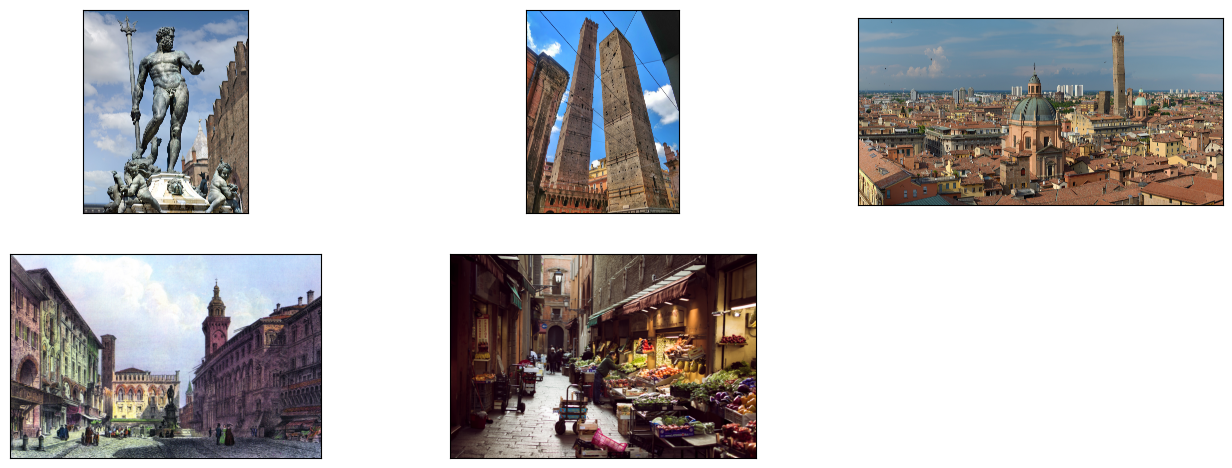

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./mixed_wiki"):
    image_paths.append(str(os.path.join("./mixed_wiki", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths[0:5]:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(3, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 9:
                break


plot_images(image_paths)

In [12]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index.core import SimpleDirectoryReader

In [18]:
# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db")

# Create QdrantVectorStore instances for text and image collections
text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)

# Create a StorageContext to hold vector and image stores
storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# Load data from a SimpleDirectoryReader for creating the MultiModal index
documents = SimpleDirectoryReader("mixed_wiki/").load_data()

# Create a MultiModalVectorStoreIndex from the loaded documents
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

c:\Users\vaalt\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (95253504 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [17]:
client.close()

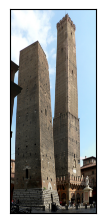

In [13]:
input_image = "./mixed_wiki/2.jpg"
plot_images([input_image])

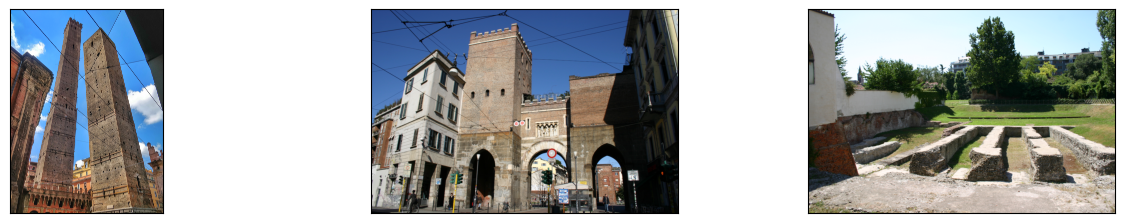

In [19]:
# generate Text retrieval results
retriever_engine = index.as_retriever(image_similarity_top_k=4)
# retrieve more information from the GPT4V response
retrieval_results = retriever_engine.image_to_image_retrieve(
    "./mixed_wiki/2.jpg"
)
retrieved_images = []
for res in retrieval_results:
    retrieved_images.append(res.node.metadata["file_path"])

# Remove the first retrieved image as it is the input image
# since the input image will gethe highest similarity score
plot_images(retrieved_images[1:])

In [22]:
from llama_index.core import SimpleDirectoryReader
from llama_index.core.schema import ImageDocument

# put your local directore here
image_documents = [ImageDocument(image_path=input_image)]

for res_img in retrieved_images[1:]:
    image_documents.append(ImageDocument(image_path=res_img))

response = llm_vision.complete(
    prompt="Given the first image as the base image, what the other images correspond to? Give me a short description",
    image_documents=image_documents,
)

print(response)

The first image corresponds to the Two Towers of Bologna, Italy. The second image is another angle of the Two Towers. The third image corresponds to the Porta Galliera, a gate of the former outer medieval walls of the city. The fourth image corresponds to the remains of the Roman amphitheater of Bologna.


In [36]:
# Create a query engine using the MultiModalVectorStoreIndex
# Supply the OpenAIMultiModal instance as the multi_modal_llm
query_engine = index.as_query_engine(
    llm=llm_vision,
    similarity_top_k=3, 
    image_similarity_top_k=3
)

# Define the query string for the multi-modal query
query_str = "what are the three most iconic places to visit in Venice?"

# Use the query engine to process the multi-modal query
response_mm = query_engine.query(query_str)

# Print the response from the query engine as a string
print(str(response_mm))

The three most iconic places to visit in Venice are St Mark's Basilica, the Doge's Palace, and the Grand Canal.


**Node ID:** 74dddef7-a564-40df-8b3a-4e60bf8cef27<br>**Similarity:** 0.8245230162927718<br>**Text:** Its shape has evolved through the centuries, as documented in many well-known paintings. Its form, topped by a likeness of the Doge's hat, became gradually standardized, and was then fixed by local law. It consists of six bars pointing forward representing the sestieri of the city, and one that points backwards representing the Giudecca. A lesser-known boat is the smaller, simpler, but similar, sandolo.


==== Waterways ====
Venice's small islands were enhanced during the Middle Ages by the dredging of soil to raise the marshy ground above the tides. The resulting canals encouraged the flourishing of a nautical culture which proved central to the economy of the city. Today those canals still provide the means for transport of goods and people within the city.
The maze of canals threading through the city requires more than 400 bridges to permit the flow of foot traffic. In 2011, the city opened the Ponte della Costituzione, the fourth bridge across the Grand Canal, which connec...<br>

**Node ID:** ba38fdd7-b1a6-4b3f-896c-48562b51f05c<br>**Similarity:** 0.8174499451637312<br>**Text:** === Tourism ===
Venice is an important destination for tourists who want to see its celebrated art and architecture. The city hosts up to 60,000 tourists per day (2017 estimate). Estimates of the annual number of tourists vary from 22 million to 30 million. This "overtourism" creates overcrowding and environmental problems for Venice's ecosystem. By 2017, UNESCO was considering the addition of Venice to its "In-Danger" list, which includes historical ruins in war-torn countries. To reduce the number of visitors, who are causing irreversible changes in Venice, the agency supports limiting the number of cruise ships as well as implementing a strategy for more sustainable tourism.Tourism has been a major part of the Venetian economy since the 18th century, when Venice—with its beautiful cityscape, uniqueness, and rich musical and artistic cultural heritage—was a stop on the Grand Tour. In the 19th century, Venice became a fashionable centre for the "rich and famous", who often stayed ...<br>

**Node ID:** 2f70d404-1a05-4750-bc98-7d18e1b8f647<br>**Similarity:** 0.8161777072051108<br>**Text:** Chandeliers were usually very colourful, using Murano glass to make them look more vibrant and stand out from others; and precious stones and materials from abroad were used, since Venice still held a vast trade empire. Lacquer was very common, and many items of furniture were covered with it, the most noted being lacca povera (poor lacquer), in which allegories and images of social life were painted. Lacquerwork and Chinoiserie were particularly common in bureau cabinets.


=== Glass ===

Venice is known for its ornate glass-work, known as Venetian glass, which is world-renowned for being colourful, elaborate, and skilfully made. Many of the important characteristics of these objects had been developed by the 13th century. Toward the end of that century, the centre of the Venetian glass industry moved to Murano, an offshore island in Venice. The glass made there is known as Murano glass.
Byzantine craftsmen played an important role in the development of Venetian glass. When C...<br>

c:\Users\vaalt\AppData\Local\anaconda3\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (95253504 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


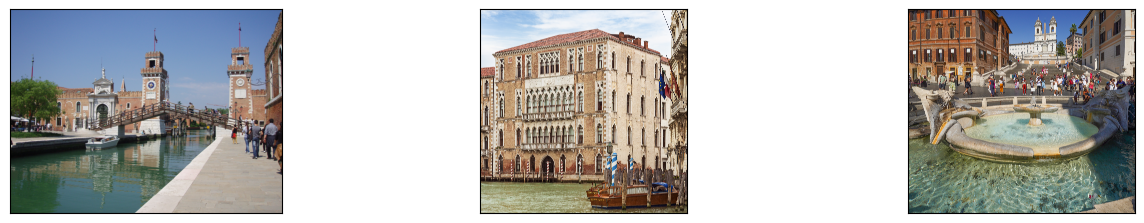

In [38]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode

# Iterate through each text node in the response metadata
for text_node in response_mm.metadata["text_nodes"]:
    # Display the source node using the display_source_node utility
    # Limit the displayed source length to 200 characters
    display_source_node(text_node, source_length=1000)

# Plot images using the plot_images function
# The image paths are extracted from the image nodes in the response metadata
plot_images(
    [n.metadata["file_path"] for n in response_mm.metadata["image_nodes"]]
)

In [39]:
response_mm.metadata

{'text_nodes': [NodeWithScore(node=TextNode(id_='74dddef7-a564-40df-8b3a-4e60bf8cef27', embedding=None, metadata={'file_path': 'c:\\Users\\vaalt\\OneDrive\\Desktop\\Projects\\Eventi speaker\\ODSC 2024 Boston\\mixed_wiki\\Venice.txt', 'file_name': 'Venice.txt', 'file_type': 'text/plain', 'file_size': 80269, 'creation_date': '2024-02-25', 'last_modified_date': '2024-02-25'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='ec559c28-5ac0-41e0-bc41-a02d866fe469', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'c:\\Users\\vaalt\\OneDrive\\Desktop\\Projects\\Eventi speaker\\ODSC 2024 Boston\\mixed_wiki\\Venice.txt', 'file_name': 'Venice.txt', 'file_type': 'text/plain', 'file_size': 80269, 'creation_d

In [40]:
documents

[ImageDocument(id_='1279fed2-9d31-4833-a92e-8204f0558817', embedding=None, metadata={'file_path': 'c:\\Users\\vaalt\\OneDrive\\Desktop\\Projects\\Eventi speaker\\ODSC 2024 Boston\\mixed_wiki\\1.jpg', 'file_name': '1.jpg', 'file_type': 'image/jpeg', 'file_size': 3874842, 'creation_date': '2024-02-25', 'last_modified_date': '2024-02-25'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='c:\\Users\\vaalt\\OneDrive\\Desktop\\Projects\\Eventi speaker\\ODSC 2024 Boston\\mixed_wiki\\1.jpg', image_url=None, image_mimetype=None, text_embedding=None),
 ImageDocument(id_='7ed6a210-c2af-4731-9ece-